In [1]:
import pandas as pd
import numpy as np
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import random
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
from sklearn.model_selection import train_test_split
import os
from tqdm import tqdm
from scipy import stats
from Bio.Seq import Seq
from plotnine import *

## TPM

In [2]:
human_tpm = pd.read_table('/home/user/data3/yangsh/projects/inversion/DEG/rank_TPM-2019-PNAS/2021-NC-Raquel/TPM/human_tpm.txt',index_col='Geneid')
macaca_tpm = pd.read_table('/home/user/data3/yangsh/projects/inversion/DEG/rank_TPM-2019-PNAS/2021-NC-Raquel/TPM/macaca_tpm.txt',index_col='Geneid')

In [3]:
def plot_boxplot(geneid):
    human_tpm_gene = list(human_tpm.loc[geneid])
    macaca_tpm_gene = list(macaca_tpm.loc[geneid])

    data = {
        "HomSap": human_tpm_gene,
        "MacMac": macaca_tpm_gene,
    }

    df = pd.DataFrame({
        "value": np.concatenate(list(data.values())),
        "group": np.repeat(list(data.keys()), [len(v) for v in data.values()])
    })

    median_order = (
        df.groupby("group")["value"]
        .median()
        .sort_values()
        .index.tolist()
    )

    df["group"] = pd.Categorical(df["group"], categories=median_order, ordered=True)

    plot = (
        ggplot(df, aes(x="group", y="value",fill='group'))
        + geom_boxplot()
        + theme_bw()
        + scale_x_discrete(name="Groups (sorted by median)")
    )

    print(plot)

/tmp/ipykernel_115012/4118908961.py:31: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


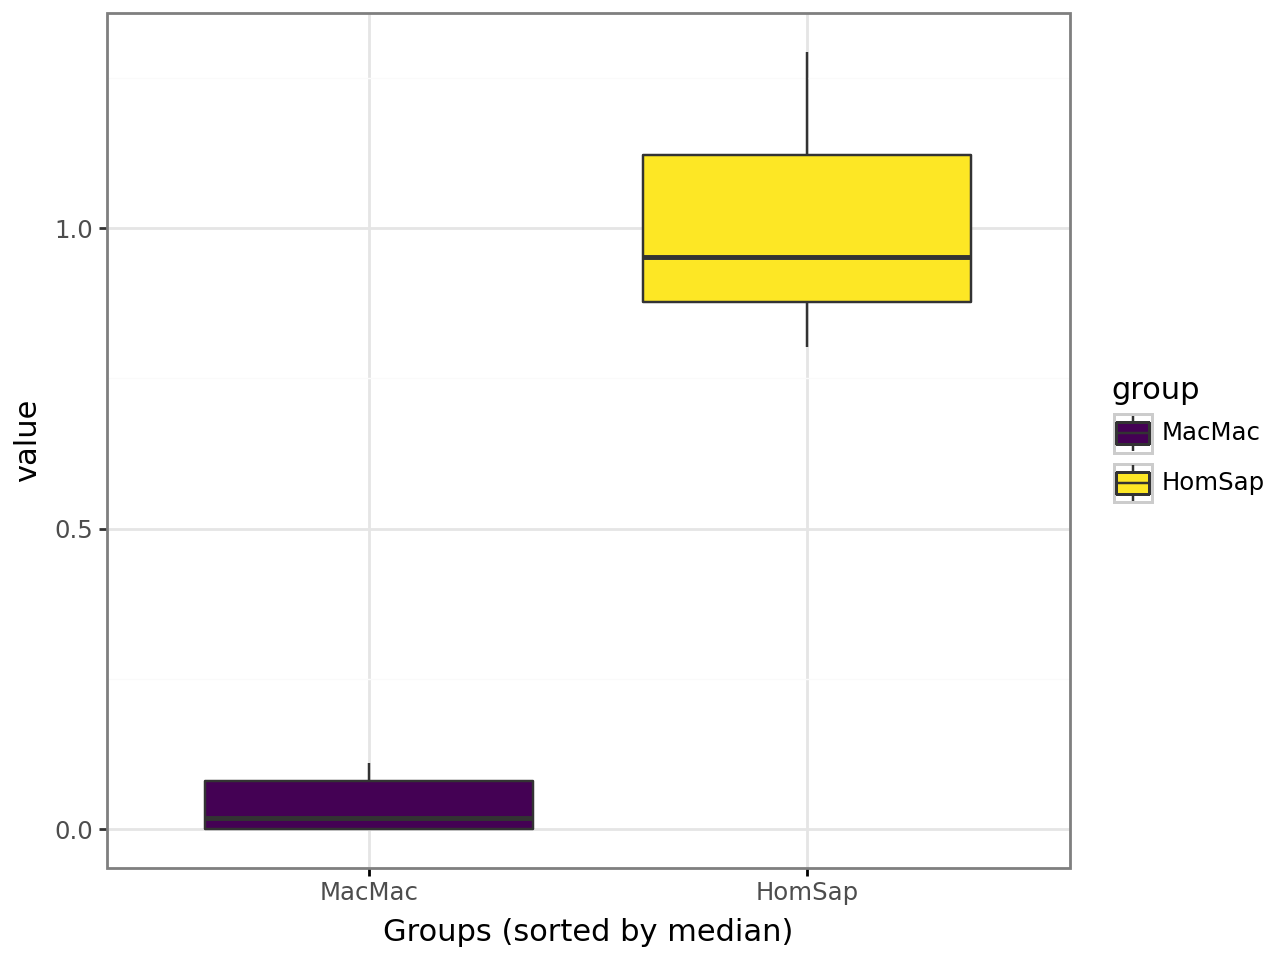

In [4]:
plot_boxplot('TCL1B')

## Sequence

In [5]:
with open('../Demo_data/Sequence_dict.json', 'rb') as fp:
    sequence_dict = pickle.load(fp)

## Model load

In [6]:
class GELU(nn.Module):
    def forward(self, x):
        return torch.nn.functional.gelu(x)

class Residual(nn.Module):
    def __init__(self, module):
        super(Residual, self).__init__()
        self.module = module

    def forward(self, x):
        return x + self.module(x)
    
class SoftmaxPooling1D(nn.Module):
    def __init__(self, pool_size=2, per_channel=False, w_init_scale=0.0):
        super(SoftmaxPooling1D, self).__init__()
        self.pool_size = pool_size
        self.per_channel = per_channel
        self.w_init_scale = w_init_scale

    def forward(self, inputs):
        batch_size, channels, length = inputs.size()
        inputs = inputs.view(batch_size, channels, length // self.pool_size, self.pool_size)
        weights = torch.softmax(self.w_init_scale * inputs, dim=-1)
        return torch.sum(inputs * weights, dim=-1)

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, pool_size):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, padding='same')
        self.bn = nn.BatchNorm1d(out_channels)
        self.pool = nn.MaxPool1d(pool_size)
        self.gelu = GELU()
    
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.gelu(x)
        x = self.pool(x)
        return x
    
class TargetLengthCrop1D(nn.Module):
    def __init__(self, target_length):
        super(TargetLengthCrop1D, self).__init__()
        self.target_length = target_length
        
    def forward(self, inputs):
        if self.target_length is None:
            return inputs
        trim = (inputs.shape[-1] - self.target_length) // 2
        if trim < 0:
            return inputs
        elif trim == 0:
            return inputs
        else:
            return inputs[..., trim:-trim]

class DeepEvo_Seq2Epi(nn.Module):
    def __init__(self, channels=1408, num_transformer_layers=6, num_heads=8, pooling_type='attention'):
        super(DeepEvo_Seq2Epi, self).__init__()
        assert channels % num_heads == 0, "channels needs to be divisible by num_heads"

        self.stem = nn.Sequential(
            nn.Conv1d(4, 256, kernel_size=15, padding='same'),
            Residual(ConvBlock(256, 256, kernel_size=1, pool_size=1)),
            SoftmaxPooling1D(pool_size=2) if pooling_type == 'attention' else nn.MaxPool1d(pool_size=2)
        )

        filter_list = self.exponential_linspace_int(256, 512, num=7, divisible_by=32)
        conv_blocks = []
        for in_channels, out_channels in zip(filter_list[:-1], filter_list[1:]):
            conv_blocks.append(ConvBlock(in_channels, out_channels, kernel_size=20, pool_size=1))
            conv_blocks.append(Residual(ConvBlock(out_channels, out_channels, kernel_size=1, pool_size=1)))
            if pooling_type == 'attention':
                conv_blocks.append(SoftmaxPooling1D(pool_size=2))
            else:
                conv_blocks.append(nn.MaxPool1d(pool_size=2))
        self.conv_tower = nn.Sequential(*conv_blocks)

        self.crop_final = TargetLengthCrop1D(1152)
        self.final_pointwise = nn.Sequential(
            ConvBlock(512, 512, kernel_size=1, pool_size=1),
            nn.Dropout(0.3),
            GELU()
        )

        self.heads = nn.ModuleDict({
            'all_species': 
            nn.Sequential(
                nn.Conv1d(512, 5, kernel_size=1),
                nn.Softplus()
            )
        })
    
    def forward(self, x1):
        x1 = self.stem(x1)
        x1 = self.conv_tower(x1)

        x1 = self.crop_final(x1)
        x1 = self.final_pointwise(x1)
        output = self.heads['all_species'](x1)
        return output

    @staticmethod
    def exponential_linspace_int(start, end, num, divisible_by=1):
        def _round(x):
            return int(np.round(x / divisible_by) * divisible_by)
        base = np.exp(np.log(end / start) / (num - 1))
        return [_round(start * base**i) for i in range(num)]

In [7]:
save_path = '../Model/DeepEvo_Seq2Epi_LCL.pth'
model_seq2epi = DeepEvo_Seq2Epi()
state_dict = torch.load(save_path, map_location='cpu')
model_seq2epi.load_state_dict(state_dict, strict=True)
model_seq2epi = model_seq2epi.eval()

/tmp/ipykernel_115012/480556414.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


In [8]:
class DeepEvo_Epi2DEG(nn.Module):
    def __init__(self):
        super(DeepEvo_Epi2DEG, self).__init__()
        
        self.conv1d_shared1 = nn.Conv1d(5, 32, kernel_size=1, stride=1)
        self.conv1d_shared2 = nn.Conv1d(32, 64, kernel_size=1, stride=1)
        self.conv1d_shared3 = nn.Conv1d(64, 64, kernel_size=1, stride=1)
        self.pool1 = nn.AvgPool1d(kernel_size=4, stride=4)
        self.pool2 = nn.AvgPool1d(kernel_size=8, stride=8)
        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(64 * 36, 32)
        self.fc2 = nn.Linear(64, 3)

    def forward_once(self, x):
        x = self.conv1d_shared1(x)
        x = self.dropout(x)
        x = self.pool1(x)
        x = self.conv1d_shared2(x)
        x = self.dropout(x)
        x = self.pool2(x)
        x = self.conv1d_shared3(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return x
    
    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        output = torch.cat((output1, output2), dim=1)
        output = self.fc2(output)
        return output

In [9]:
save_path = '../Model/DeepEvo_Epi2DEG_LCL.pth'
model_epi2deg = DeepEvo_Epi2DEG()
state_dict = torch.load(save_path, map_location='cpu')
model_epi2deg.load_state_dict(state_dict, strict=True)
model_epi2deg = model_epi2deg.eval()

/tmp/ipykernel_115012/4271429628.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


## prediction

In [10]:
def fill_with_N(s, target_length):
    if len(s) <= target_length:
        return s.center(target_length, 'N')
    else:
        current_length = len(s)
        trimming_length = current_length - target_length
        left_trim = trimming_length // 2
        right_trim = trimming_length - left_trim
        return s[left_trim:current_length - right_trim]

def pad_to_multiple_of_128(s, pad_char='N'):
    length = len(s)
    padding_needed = (128 - length % 128) % 128
    if padding_needed == 0:
        return s
    left_padding = padding_needed // 2
    right_padding = padding_needed - left_padding
    padded_string = s + pad_char * padding_needed
    return padded_string

def one_hot_encode_sequence(sequence):
    sequence = sequence.upper()
    bases = 'ACGT'
    one_hot = np.zeros((len(sequence), 4), dtype=np.int8)
    for i, base in enumerate(sequence):
        if base in bases:
            one_hot[i, bases.index(base)] = 1
        else:
            one_hot[i, :] = [0, 0, 0, 0]
    return one_hot

def process_seq(aligned_seq_human, target_length):
    aligned_seq_human_no_dash = aligned_seq_human.replace("-", "")
    aligned_seq_human_no_dash_padding = fill_with_N(aligned_seq_human_no_dash, target_length=target_length)
    aligned_seq_human_onehot = one_hot_encode_sequence(aligned_seq_human_no_dash_padding)
    return aligned_seq_human_onehot

def predict_Epi(module, aligned_seq_human, target_length):
    aligned_seq_human_onehot = process_seq(aligned_seq_human, target_length)
    aligned_seq_human_onehot = np.expand_dims(aligned_seq_human_onehot, axis=0)
    aligned_seq_human_onehot = torch.tensor(aligned_seq_human_onehot)
    aligned_seq_human_onehot = torch.transpose(aligned_seq_human_onehot, 1, 2)
    aligned_seq_human_onehot = aligned_seq_human_onehot.float()
    aligned_seq_human_onehot = aligned_seq_human_onehot
    with torch.no_grad():
        output_row = module(aligned_seq_human_onehot)
    return output_row.to('cpu')

def predict_DEG(sequence1, sequence2):
    with torch.no_grad():
        Epi_res1 = predict_Epi(model_seq2epi, sequence1, 180224)
        Epi_res2 = predict_Epi(model_seq2epi, sequence2, 180224)
        output = model_epi2deg(Epi_res1, Epi_res2)
    output_cpu = output.to('cpu')
    non_deg_score = output_cpu[0, 0].item()
    seq1_high_score = output_cpu[0, 1].item()
    seq2_high_score = output_cpu[0, 2].item()
    print('-' * 40)
    print('Model Prediction Summary:')
    print(f'NonDEG Score     : {non_deg_score:.4f}')
    print(f'Seq1 High Score  : {seq1_high_score:.4f}')
    print(f'Seq2 High Score  : {seq2_high_score:.4f}')
    print('-' * 40)
    scores = {
        'NonDEG': non_deg_score,
        'Seq1_High': seq1_high_score,
        'Seq2_High': seq2_high_score
    }
    
    return scores

In [11]:
sequence_human = sequence_dict['TCL1B']['Human']
sequence_rhesus = sequence_dict['TCL1B']['Rhesus']

In [13]:
scores = predict_DEG(sequence_human, sequence_rhesus)

/home/user/BGM/qij/miniconda3/envs/deep_learning/lib/python3.10/site-packages/torch/nn/modules/conv.py:304: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1031.)


----------------------------------------
Model Prediction Summary:
NonDEG Score     : -0.1940
Seq1 High Score  : -0.4813
Seq2 High Score  : 0.5271
----------------------------------------
